In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Functions

original_df = pd.read_csv("./FIFA18_players_database/CompleteDataset.csv", low_memory=False)
original_df = Functions.engineer_features(original_df)
original_df = original_df.sample(frac=1).reset_index(drop=True)
X_train, X_test, y_train, y_test = Functions.split_data(original_df, 0)
X_train_minmax = Functions.normalize(X_train, "minmax")
X_test_minmax = Functions.normalize(X_test, "minmax")
X_train_standard = Functions.normalize(X_train, "standard")
X_test_standard = Functions.normalize(X_test, "standard")

print("Running models with outliers present: ")

# Run gaussian naive bayes
y_test_pred, y_train_pred = Functions.run_naive_bayes(X_train, X_test, y_train)
y_test_pred_minmax, y_train_pred_minmax = Functions.run_naive_bayes(X_train_minmax, X_test_minmax, y_train)
y_test_pred_standard, y_train_pred_standard = Functions.run_naive_bayes(X_train_standard, X_test_standard, y_train)
acc = Functions.accuracy_scorer(y_test, y_test_pred)
acc_minmax = Functions.accuracy_scorer(y_test, y_test_pred_minmax)
acc_standard = Functions.accuracy_scorer(y_test, y_test_pred_standard)
print(f"Accuracy Gaussian Naive Bayes: {acc}")
print(f"Accuracy Gaussian Naive Bayes min max normalized: {acc_minmax}")
print(f"Accuracy Gaussian Naive Bayes standardized: {acc_standard}\n")

values = {
    "Not normalized, with outliers": acc * 100,
    "Minmax normalized, with outliers": acc_minmax * 100,
    "Standardized, with outliers": acc_standard * 100,
    "Not normalized, no outliers": 0,
    "Minmax normalized, no outliers": 0,
    "Standardized, no outliers": 0,
    "Model after cross-validation": 0,
}

# Remove outliers
outlier_free_df = Functions.remove_outliers(original_df, 1)

print("Running models without outliers present: ")

# Run gaussian naive bayes
X_train, X_test, y_train, y_test = Functions.split_data(outlier_free_df, 0)
X_train_minmax = Functions.normalize(X_train, "minmax")
X_test_minmax = Functions.normalize(X_test, "minmax")
X_train_standard = Functions.normalize(X_train, "standard")
X_test_standard = Functions.normalize(X_test, "standard")
y_test_pred, y_train_pred = Functions.run_naive_bayes(X_train, X_test, y_train)
y_test_pred_minmax, y_train_pred_minmax = Functions.run_naive_bayes(X_train_minmax, X_test_minmax, y_train)
y_test_pred_standard, y_train_pred_standard = Functions.run_naive_bayes(X_train_standard, X_test_standard, y_train)
acc = Functions.accuracy_scorer(y_test, y_test_pred)
acc_minmax = Functions.accuracy_scorer(y_test, y_test_pred_minmax)
acc_standard = Functions.accuracy_scorer(y_test, y_test_pred_standard)
print(f"Accuracy Gaussian Naive Bayes: {acc}")
print(f"Accuracy Gaussian Naive Bayes min max normalized: {acc_minmax}")
print(f"Accuracy Gaussian Naive Bayes standardized: {acc_standard}\n")

values["Not normalized, no outliers"] = acc * 100
values["Minmax normalized, no outliers"] = acc_minmax * 100
values["Standardized, no outliers"] = acc_standard * 100

# Choose best model with cross-validation
max_acc = 0
for i in range(5):
    X_train, X_test, y_train, y_test = Functions.split_data(outlier_free_df, i)
    
    y_test_pred, y_train_pred = Functions.run_naive_bayes(X_train, X_test, y_train)
    acc = Functions.accuracy_scorer(y_test, y_test_pred)
    
    print("Split", i + 1, "accuracy:", acc)
    
    if acc > max_acc:
        max_acc = acc

values["Model after cross-validation"] = max_acc * 100
        
print("Best accuracy model after cross-validation: ", max_acc)    

Running models with outliers present: 
Accuracy Gaussian Naive Bayes: 0.6123472265747415
Accuracy Gaussian Naive Bayes min max normalized: 0.6063929802569727
Accuracy Gaussian Naive Bayes standardized: 0.5985584456283297

Running models without outliers present: 
Accuracy Gaussian Naive Bayes: 0.626428216592151
Accuracy Gaussian Naive Bayes min max normalized: 0.6234475906607054
Accuracy Gaussian Naive Bayes standardized: 0.6130153999006458

Split 1 accuracy: 0.626428216592151
Split 2 accuracy: 0.6582215598609041
Split 3 accuracy: 0.6462990561351217
Split 4 accuracy: 0.6294088425235966
Split 5 accuracy: 0.6328358208955224
Best accuracy model after cross-validation:  0.6582215598609041


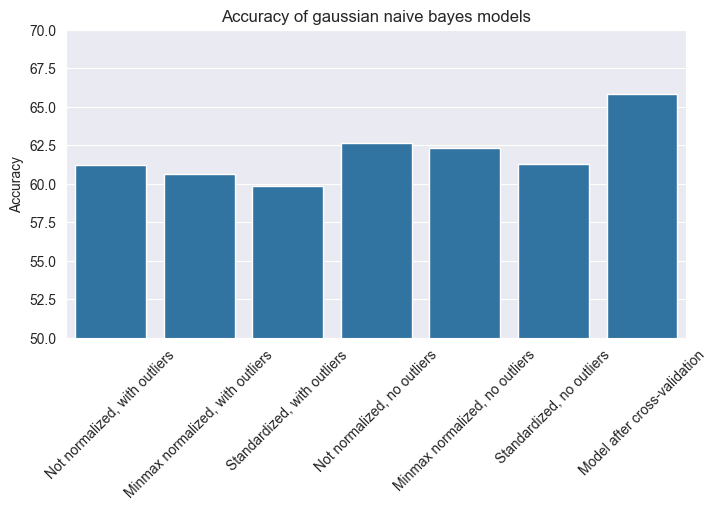

In [21]:
plt.figure(figsize=(8, 4))
sns.barplot(values)
plt.title("Accuracy of gaussian naive bayes models")
plt.ylabel("Accuracy")
plt.ylim(50, 70)
plt.xticks(rotation=45)
plt.show()